## Current status
- The current goal is to make standard QAOA work with adiabatic-like trajectories.
- L-BFGS-B optimizer (bounded) needs a lot of layers to find the factorization solution. From $p \sim 40$ layers, the
angle trajectories stops being quasi-adiabatic: some oscillations and sudden drops appear for $\gamma$.
- BFGS (unbounded) finds the solution with fidelity $1$ using only $p \sim 30$ layers. For L-BFGS-B, we need more than
$100$ layers to achieve comparable results. BFGS doesn't reflect any similarity to adiabaticity.

### Things I've tried
- Multiple definitions for max_gamma ($\gamma \in [0, \text{max\_gamma}]$): using maximum E, norm of E, two or three times the original definition, etc.
- Multiple allowed intervals for $\beta$: $[0, \pi],~[0, 2\pi],~[0, \pi/2],~[-\pi/4, \pi/4],~\dots$
- Multiple optimizers: BFGS, L-BFGS-B, COBYLA, Nelder-Mead
- Multiple optimizer options: tolerances, maximum iterations, etc.
- Rescaling Hamiltonians: max_E $\rightarrow$ 1

### Things I've checked
- Cost Hamiltonians are defined correctly, encoding the solution in the ground state.
- For $p=1$ layer, multiple initializations converge to the same optimal point. The cost function only has one minimum
in the main branch for $\gamma$ and $\beta$.
- Gradients are computed correctly, double checked against the energy profile.
- Interpolation is computed correctly.

### Doubts
- I understand that it's been observed that optimal QAOA trajectories tend to mimic adiabatic passages for MaxCut and
QUBO problems. Is our problem really a QUBO problem?
- Should the trajectories be perfectly adiabatic or some oscillations are accepted?
- With current results (BFGS), can we draw any conclusions concerning adiabatic factorization?

### Next steps
- Explore adiabaticity in our method. Linear hamiltonian. N=39
- Try boundary approach with our method. N=39
- Explore N=51 or N=77.
- Prepare presentation with results: boundary vs best for standard, bounded (start with +-+-+) vs unbounded for linear (¿adiabatic?)

https://arxiv.org/pdf/2309.15162

## Preprocessing

In [1]:
from datetime import datetime, date
import math
import os
import warnings

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import scipy
from statsmodels.nonparametric.smoothers_lowess import lowess
from IPython.display import display, Markdown, Latex

from qaoa_solver import QAOASolver
from utils import int_to_binary_str, compute_solution, compute_fidelity


pd.set_option('display.max_columns', None)

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
experiment_names = os.listdir('experiments/results')
experiment_names = [name for name in experiment_names if not name.startswith('test')]
experiment_results = []

for experiment in experiment_names:

    experiment_result_files = os.listdir(f'experiments/results/{experiment}')
    
    for result_file in experiment_result_files:
        result_date = datetime.strptime(result_file.split('_')[-1].split('.json')[0], '%Y%m%d%H%M%S%f').date()
        result = pd.read_json(f'experiments/results/{experiment}/{result_file}',lines=True)
        result['date'] = result_date
        experiment_results.append(result)


experiment_results = pd.concat(experiment_results)
experiment_results['num_qubits'] = experiment_results['nx'] + experiment_results['ny']
experiment_results['optimizer'] = experiment_results['config'].apply(lambda c: c.get('optimizer'))
experiment_results['problem_hamiltonian'] = experiment_results['config'].apply(lambda c: c.get('problem_hamiltonian'))
experiment_results['cost_hamiltonian'] = experiment_results['config'].apply(lambda c: c.get('cost_hamiltonian'))
experiment_results['gamma_0'] = experiment_results['config'].apply(lambda c: c.get('initial_gamma'))
experiment_results['beta_0'] = experiment_results['config'].apply(lambda c: c.get('initial_beta'))
experiment_results['experiment'] = experiment_results['config'].apply(lambda c: c.get('experiment'))
experiment_results['extended_qaoa'] = experiment_results['config'].apply(lambda c: c.get('extended_qaoa', False))
experiment_results['max_layers'] = experiment_results['config'].apply(lambda c: c.get('layers'))
experiment_results['commit_date'] = pd.to_datetime(experiment_results['config'].apply(lambda c: c.get('commit_date')))
experiment_results['setup'] = experiment_results['experiment'].str.split('_').str[1:].str.join('_')
experiment_results['state_populations'] = experiment_results['state'].apply(lambda s: [abs(complex(c))**2 for c in s])
experiment_results['solution'] = experiment_results.apply(lambda row: compute_solution(row['N']), axis=1)
experiment_results['fidelity'] = experiment_results.apply(lambda row: compute_fidelity(row['state_populations'], row['solution']), axis=1)

experiment_results = experiment_results[(experiment_results['extended_qaoa']==False)]

In [3]:
Ns = sorted(experiment_results['N'].unique())
cost_Hs = sorted(experiment_results['cost_hamiltonian'].unique())

dfs = []

for N in Ns:
    for Hc in cost_Hs:
        solver = QAOASolver(N=N, cost_hamiltonian=Hc)
        Ec = [E.real for E in solver.Ec]
        df = pd.DataFrame({
            'N': [N],
            'cost_hamiltonian': [Hc],
            'Ec': [Ec]
        })
        dfs.append(df)

energies_df = pd.concat(dfs, ignore_index=True)

experiment_results = experiment_results.merge(energies_df, how='left', on=['N', 'cost_hamiltonian'])
experiment_results['energy_max'] = experiment_results['Ec'].apply(lambda E: np.max(E))
experiment_results['energy_norm'] = experiment_results['Ec'].apply(lambda E: np.linalg.norm(E))
experiment_results['energy_avg'] = experiment_results['Ec'].apply(lambda E: np.average(E))

max_costs = experiment_results.groupby(['N', 'optimizer', 'setup'])['cost'].max().reset_index()
max_costs = max_costs.rename(columns={'cost': 'max_cost'})
experiment_results = experiment_results.merge(max_costs, how='left', on=['N', 'optimizer', 'setup'])
experiment_results['cost_rescaled'] = experiment_results['cost'] / experiment_results['max_cost']

In [4]:
plot_colors = [
    #[Dark ,    light]
    ["black",   "#A0A0A0"],  # Black
    ["#004C99", "#99CCFF"],  # Blue
    ["#990000", "#FF9999"],  # Red
    ["#006633", "#CCFFCC"],  # Green
    ["#b8860b", "#ffd700"],  # Golden
    ["#cc4c02", "#fe9929"],  # Orange
    ["#a10694", "#c994c7"],  # Purple
    ["#8c510a", "#d8b365"],  # Brown
    ["#0868ac", "#43a2ca"],  # Cian
]

## Comparison between optimizers (N = 15)

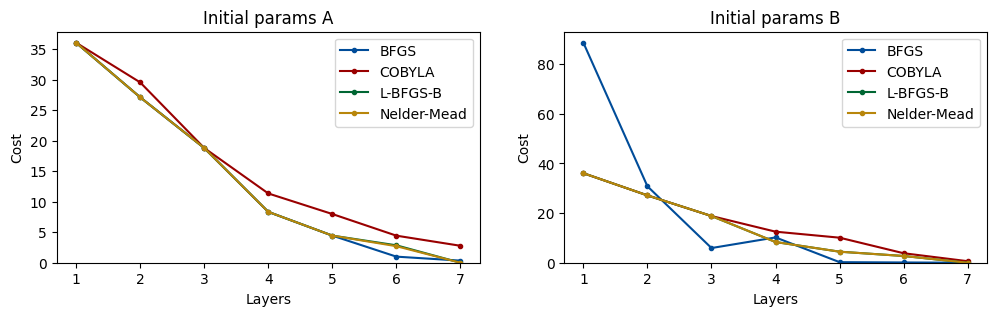

In [5]:
df = experiment_results[(experiment_results['N']==15) & (experiment_results['setup']=='standard')]
df = df.rename(columns={'optimizer_success': 'opt_succ'})

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

for j, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_opt = df[(df.optimizer == optimizer)]

    df_a = df_opt[df_opt['gamma_0'].round(5)==0.00557]
    axs[0].set_title('Initial params A')
    axs[0].plot('layers', 'cost', data=df_a, marker='.', color=plot_colors[j+1][0], label=optimizer)

    df_b = df_opt[df_opt['gamma_0'].round(5)==0.00058]
    axs[1].set_title('Initial params B')
    axs[1].plot('layers', 'cost', data=df_b, marker='.', color=plot_colors[j+1][0], label=optimizer)

for ax in axs:
    ax.set_ylabel('Cost')
    ax.set_xlabel('Layers')
    ax.set_ylim(0)
    ax.legend(loc='best')

* L-BFGS-B is the best overall optimizer among the tested methods.
* Nelder-Mead's performance is similar to L-BFGS-B, but it is in the limit of scalability.
* COBYLA has a good performance as long as a huge amount of steps are allowed, making it the
slowest of the tested methods. Even with that, the optimizer finds difficulties to succeed in
multiple occasions. It doesn't seem very appropriate for our problem.
* Since BFGS is unbounded, it is the least predictable method due to the QAOA periodic nature: $\exp (i \gamma H)$.
Interestingly, BFGS found better solutions than L-BFGS-B for some layers and converged to the problem's solution. It is sensitive to initial conditions.

## Preliminar analysis

In [6]:
solver._compute_cost([0.013,1.07])

np.float64(5898637.978299949)

0.12566370614359174


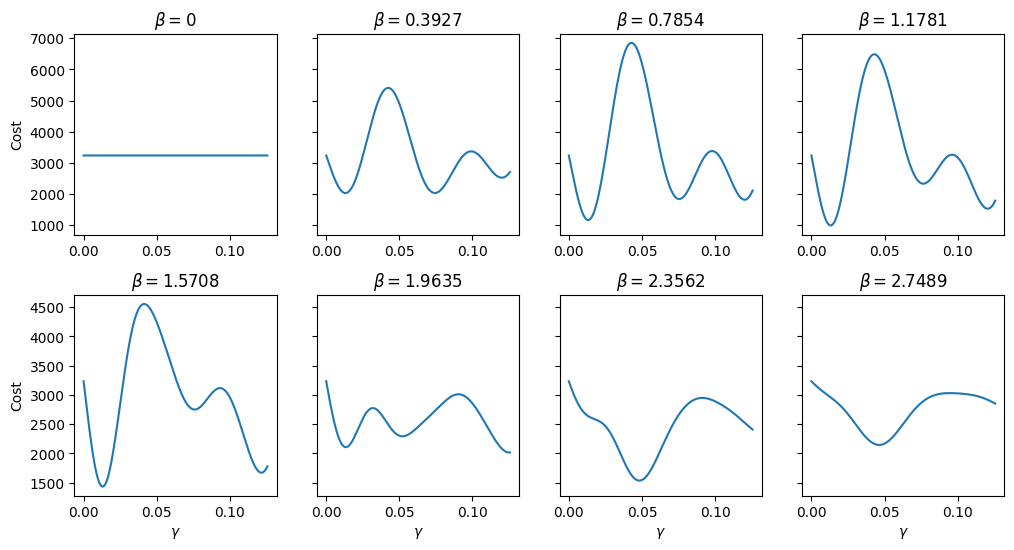

In [7]:
solver = QAOASolver(51, optimizer_method='BFGS', problem_hamiltonian='linear_H', cost_hamiltonian='quadratic_H')

# Max angle
max_gamma = 2*np.pi/max(solver.Ep)
print(max_gamma)

gammas = np.linspace(0, max_gamma, 10000)
betas = [0, np.pi/8, 2*np.pi/8, 3*np.pi/8, 4*np.pi/8, 5*np.pi/8, 6*np.pi/8, 7*np.pi/8]

fig, axs = plt.subplots(2, 4, figsize=(12,6), sharey='row', sharex=False)
axs = axs.flatten()
fig.subplots_adjust(hspace=0.3)

for i, beta in enumerate(betas):
    cost = []

    for gamma in gammas:
        res = solver._compute_cost([gamma, beta])
        cost.append(res)

    df = pd.DataFrame({'gamma': gammas, 'cost': cost})

    
    axs[i].plot('gamma', 'cost', data=df)
    axs[i].set_title(f'$\\beta = {round(beta, 4)}$')
    if i in [0,4]:
        axs[i].set_ylabel('Cost')
    if i > 3:
        axs[i].set_xlabel('$\\gamma$')

## Standard protocol

### N = 21

## N=21

**1. One layer QAOA**

,N,optimizer,layers,gamma_0,beta_0,gammas,betas,cost,fidelity
10,21,BFGS,1,0.007,1.5,[0.008278311895312],[1.529769538903815],32.774907,0.757476
0,21,L-BFGS-B,1,0.007,1.5,[0.008278311895116],[1.529769538820518],32.774907,0.757476


**2. State at layers=10**

,N,optimizer,layers,gamma_0,beta_0,cost,fidelity
19,21,BFGS,10,0.007,1.5,5.701687e-22,1.0
9,21,L-BFGS-B,10,0.007,1.5,2.852285e-09,1.0


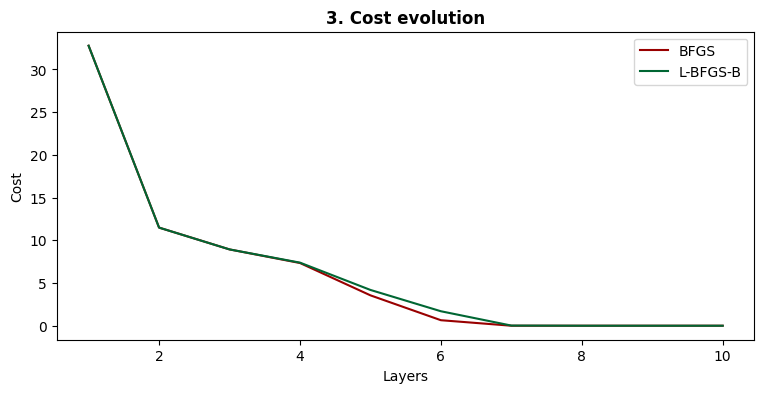

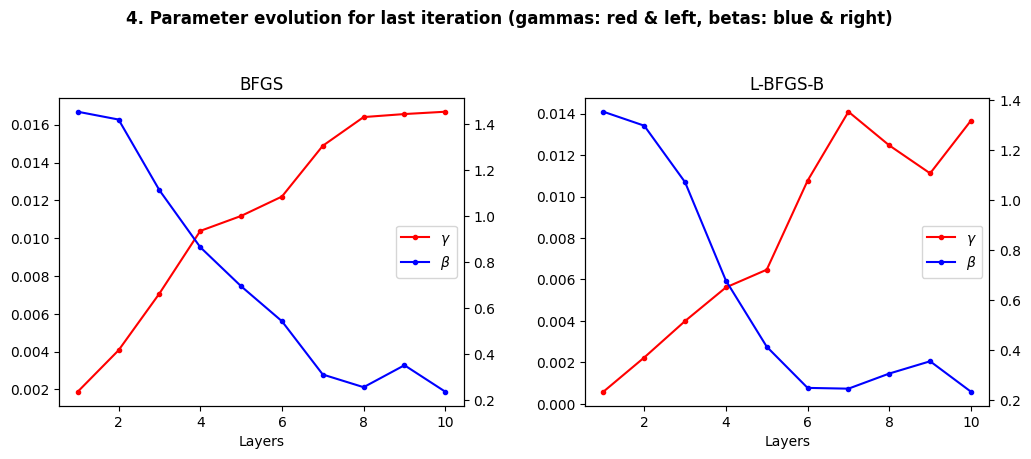

In [8]:
N = 21

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='standard')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==df['layers'].max()][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 39

## N=39

**1. One layer QAOA**

,N,optimizer,layers,gamma_0,beta_0,gammas,betas,cost,fidelity
20,39,BFGS,1,0.005,0.4,[-0.34753293794883505],[0.835908434859794],593.776847,0.021937
70,39,L-BFGS-B,1,0.005,0.4,[0.0014424208694160002],[0.540105011347612],593.675930,0.036244


**2. State at layers=30**

,N,optimizer,layers,gamma_0,beta_0,cost,fidelity
49,39,BFGS,30,0.005,0.4,0.016009,0.999343
99,39,L-BFGS-B,30,0.005,0.4,15.717973,0.386585


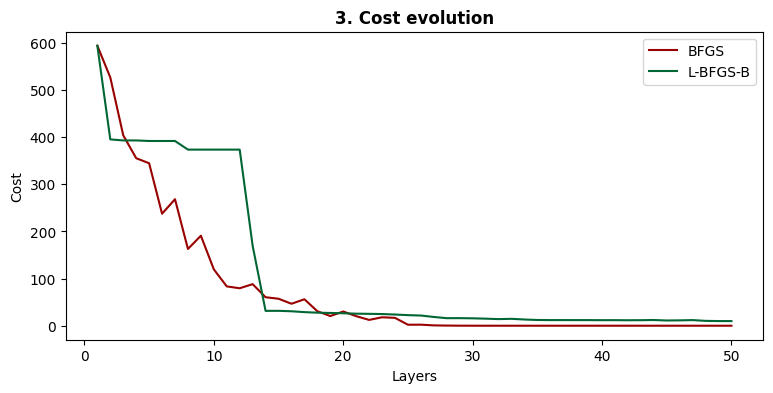

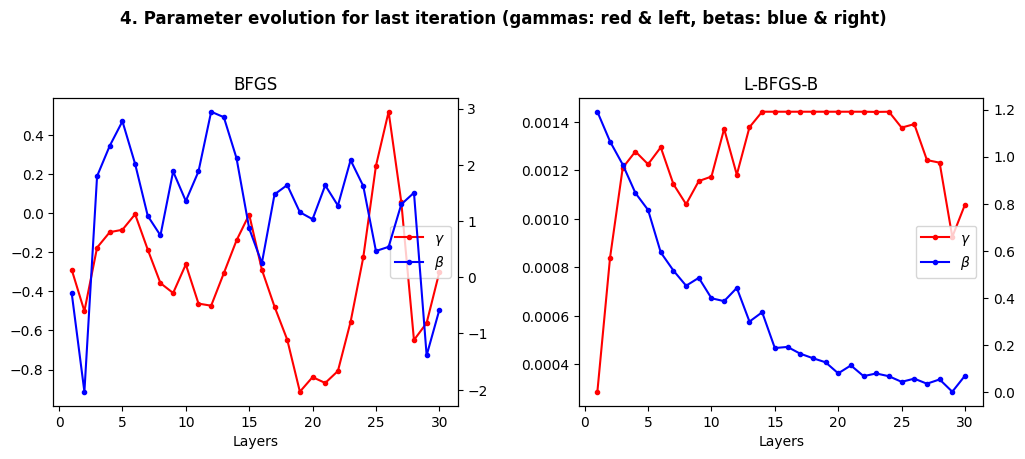

In [27]:
N = 39

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='standard')]
max_layers = 30 # int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 51

## N=51

**1. One layer QAOA**

,N,optimizer,layers,gamma_0,beta_0,gammas,betas,cost,fidelity
330,51,BFGS,1,0.0001,0.8,[7.653187295904522e-05],[0.6251993693818071],1326.671435,0.02383
280,51,L-BFGS-B,1,0.0001,0.8,[7.6531872913161e-05],[0.625199370602673],1326.671435,0.02383


**2. State at layers=50**

,N,optimizer,layers,gamma_0,beta_0,cost,fidelity
379,51,BFGS,50,0.0001,0.8,9.025102,0.069025
329,51,L-BFGS-B,50,0.0001,0.8,76.780489,0.155842


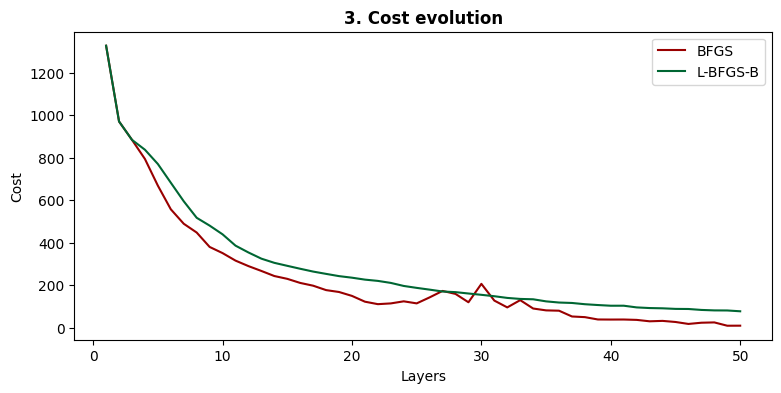

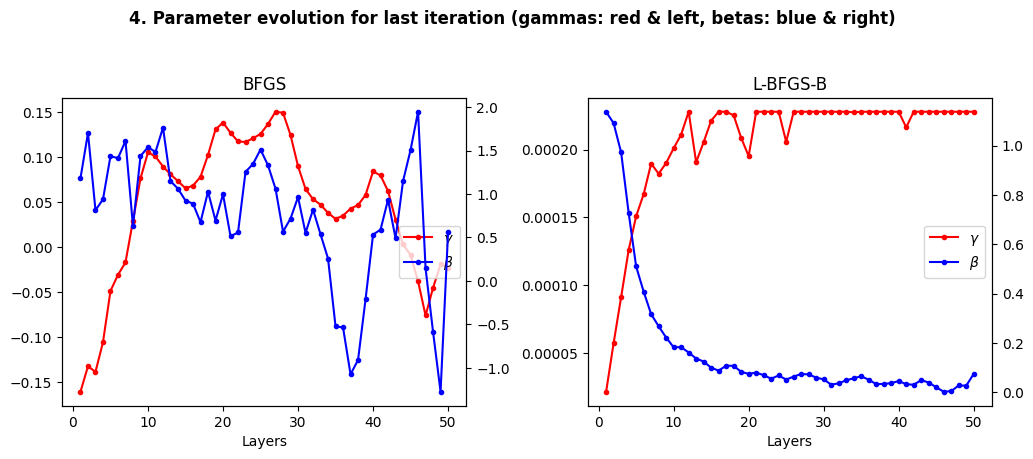

In [30]:
N = 51

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='standard')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 77

## N=77

**1. One layer QAOA**

,N,optimizer,layers,gamma_0,beta_0,gammas,betas,cost,fidelity
795,77,BFGS,1,0.0001,0.39,[0.000108307745618],[0.5230479893037681],1934.541313,0.022078
845,77,L-BFGS-B,1,0.0001,0.39,[0.000108307745781],[0.523047988282447],1934.541313,0.022078


**2. State at layers=50**

,N,optimizer,layers,gamma_0,beta_0,cost,fidelity
844,77,BFGS,50,0.0001,0.39,9.764248,0.415022
894,77,L-BFGS-B,50,0.0001,0.39,56.238237,0.138790


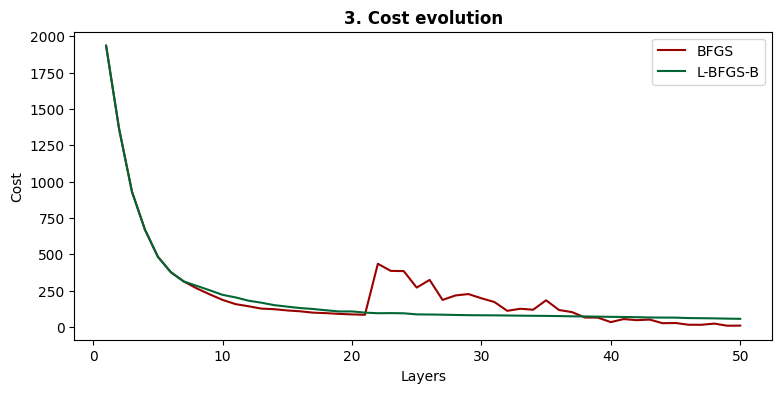

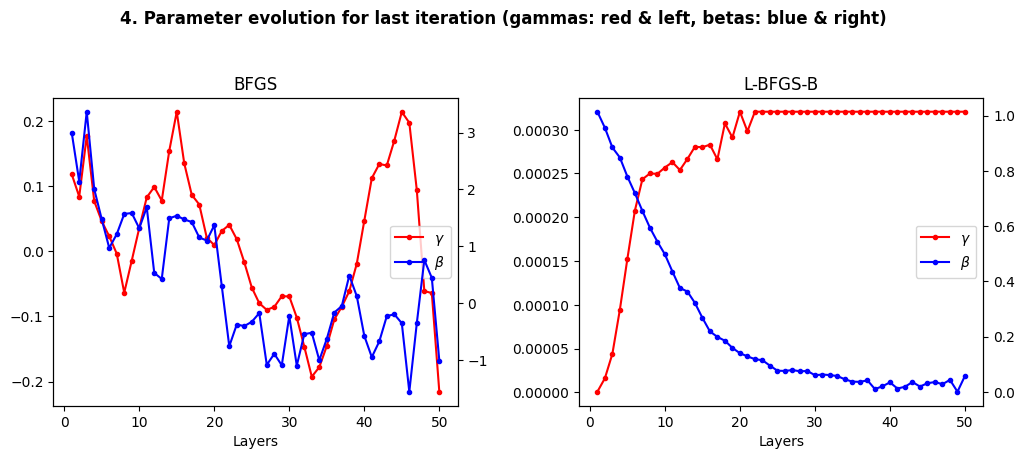

In [24]:
N = 77

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='standard')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

## Linear-quadratic protocol

### N = 21

## N=21

**1. One layer QAOA**

,N,optimizer,layers,gamma_0,beta_0,gammas,betas,cost,fidelity
490,21,BFGS,1,0.15,1.5,[0.154564850965925],[1.5075920586575662],74.357584,0.169938
480,21,L-BFGS-B,1,0.15,1.5,[0.15456485072714302],[1.507592055147221],74.357584,0.169938


**2. State at layers=10**

,N,optimizer,layers,gamma_0,beta_0,cost,fidelity
499,21,BFGS,10,0.15,1.5,1.943862e-19,1.000000
489,21,L-BFGS-B,10,0.15,1.5,3.862211e+01,0.130203


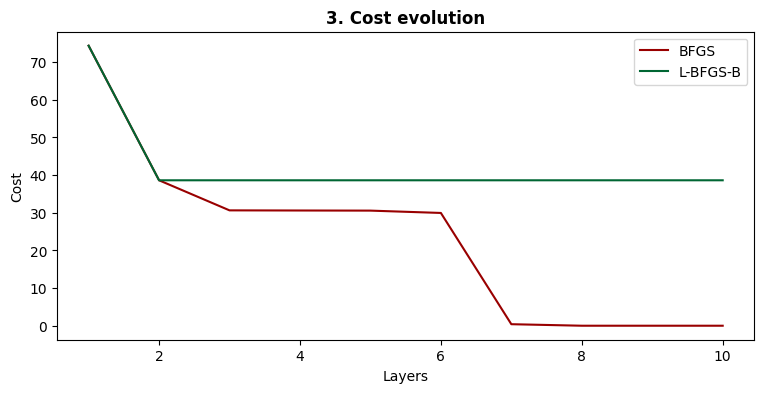

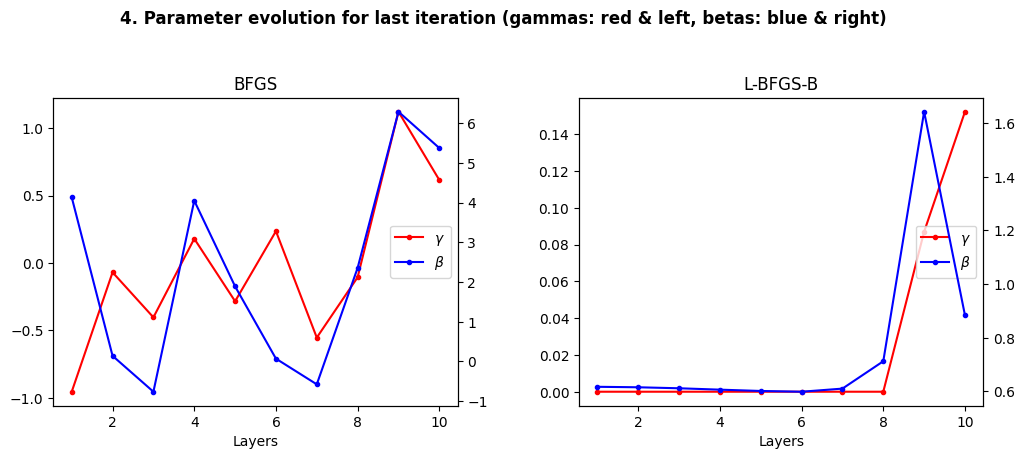

In [32]:
N = 21

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='linear_quadratic')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==df['layers'].max()][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 39

## N=39

**1. One layer QAOA**

,N,optimizer,layers,gamma_0,beta_0,gammas,betas,cost,fidelity
120,39,BFGS,1,0.05,1.5,[0.5293255227265441],[1.3622064923108401],571.618429,0.008020
150,39,L-BFGS-B,1,0.05,1.5,[0.042419916719614],[1.465584281583984],308.614459,0.046635


**2. State at layers=30**

,N,optimizer,layers,gamma_0,beta_0,cost,fidelity
149,39,BFGS,30,0.05,1.5,0.051898,0.99899
179,39,L-BFGS-B,30,0.05,1.5,129.967519,0.01601


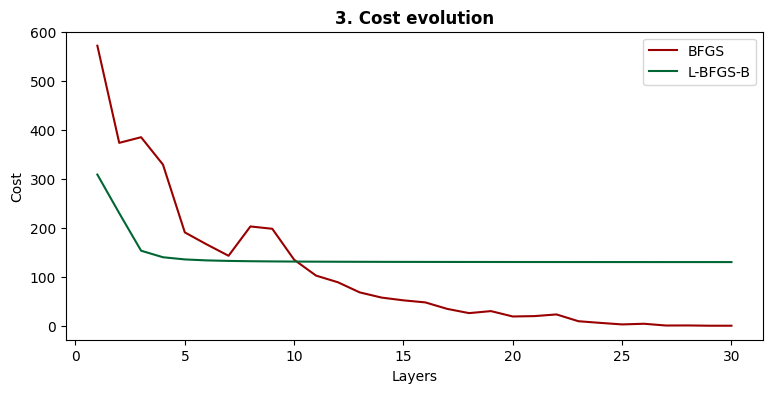

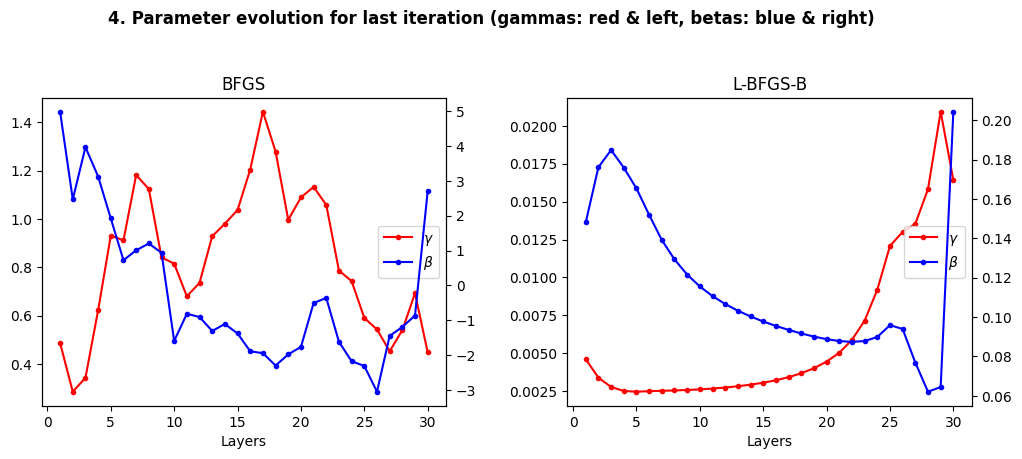

In [34]:
N = 39

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='linear_quadratic')]
max_layers = 30 # int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 51

## N=51

**1. One layer QAOA**

,N,optimizer,layers,gamma_0,beta_0,gammas,betas,cost,fidelity
595,51,BFGS,1,0.01,1.1,[0.013172117193072002],[1.071317677840412],957.604456,0.012695
645,51,L-BFGS-B,1,0.01,1.1,[0.013172117123907002],[1.071317614553077],957.604456,0.012695


**2. State at layers=50**

,N,optimizer,layers,gamma_0,beta_0,cost,fidelity
644,51,BFGS,50,0.01,1.1,6.267255,0.816719
694,51,L-BFGS-B,50,0.01,1.1,66.013635,0.342925


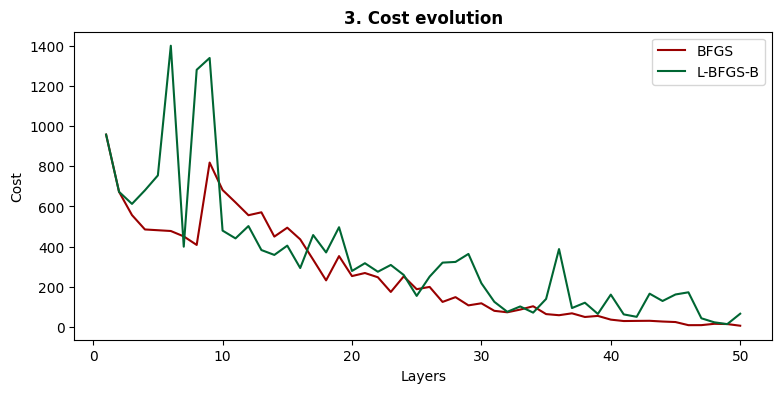

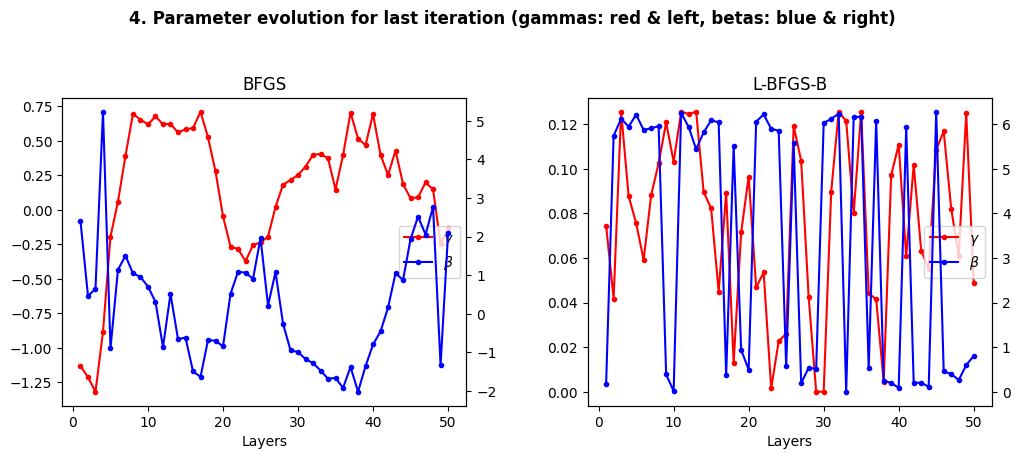

In [36]:
N = 51

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='linear_quadratic')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 77

## N=77

**1. One layer QAOA**

,N,optimizer,layers,gamma_0,beta_0,gammas,betas,cost,fidelity
230,77,BFGS,1,0.05,2.3,[0.049794543256928],[2.270977840921084],1382.099774,0.104663
180,77,L-BFGS-B,1,0.05,2.3,[0.04979454330117],[2.270977842258782],1382.099774,0.104663


**2. State at layers=50**

,N,optimizer,layers,gamma_0,beta_0,cost,fidelity
279,77,BFGS,50,0.05,2.3,9.248771,0.318659
229,77,L-BFGS-B,50,0.05,2.3,194.919376,0.322893


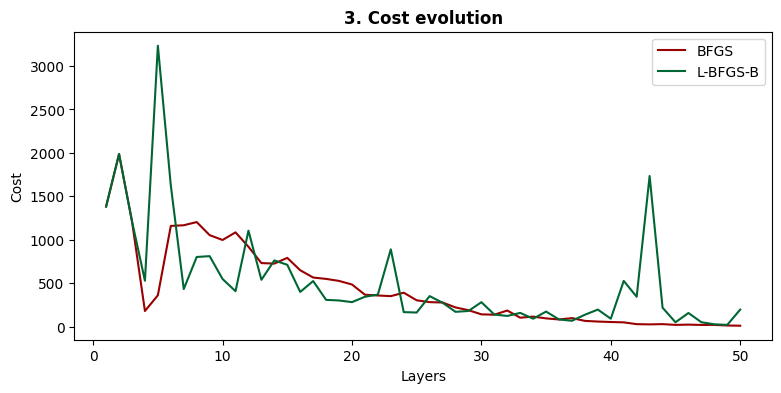

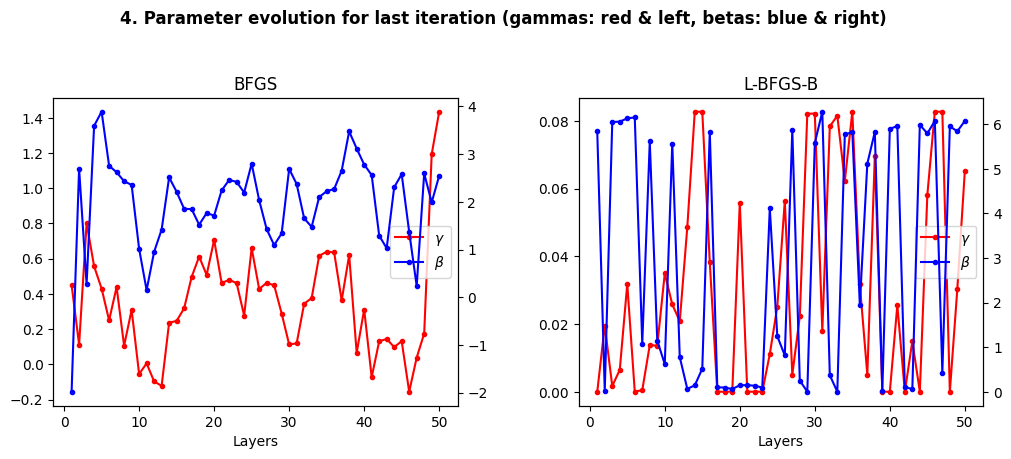

In [38]:
N = 77

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='linear_quadratic')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

## Linear-abs protocol

### N = 21

## N=21

**1. One layer QAOA**

,N,optimizer,layers,gamma_0,beta_0,gammas,betas,cost,fidelity
510,21,BFGS,1,0.15,1.5,[0.150167535914248],[1.4849625382688751],6.808984,0.174848
500,21,L-BFGS-B,1,0.15,1.5,[0.150167529669819],[1.484962492110762],6.808984,0.174848


**2. State at layers=10**

,N,optimizer,layers,gamma_0,beta_0,cost,fidelity
519,21,BFGS,10,0.15,1.5,1.570371e-17,1.000000
509,21,L-BFGS-B,10,0.15,1.5,5.524890e+00,0.149457


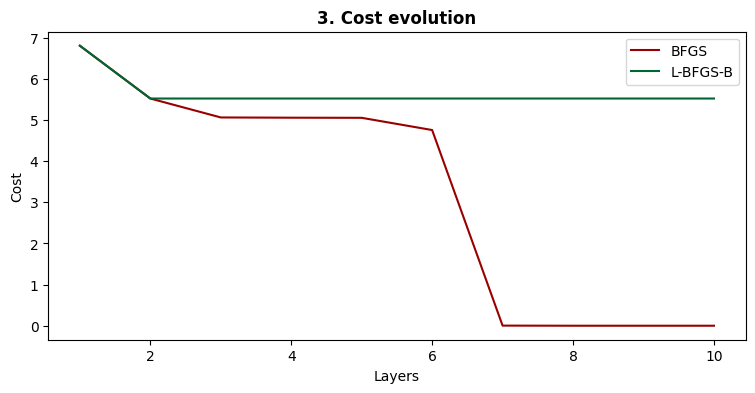

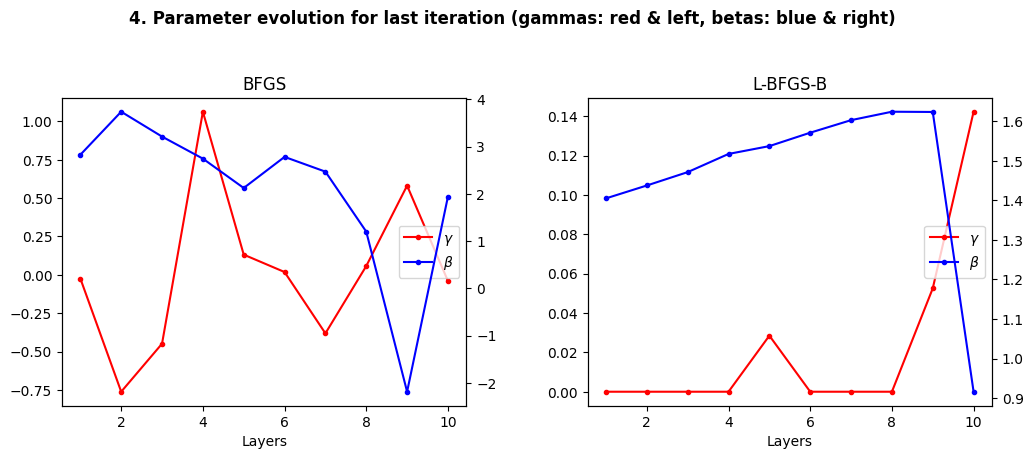

In [16]:
N = 21

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='linear_abs')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==df['layers'].max()][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 39

## N=39

**1. One layer QAOA**

,N,optimizer,layers,gamma_0,beta_0,gammas,betas,cost,fidelity
1121,39,BFGS,1,0.05,1.5,[0.043914402413695],[1.491486994085921],13.621065,0.043982
1091,39,L-BFGS-B,1,0.05,1.5,[0.043914402411096],[1.491486994120301],13.621065,0.043982


**2. State at layers=30**

,N,optimizer,layers,gamma_0,beta_0,cost,fidelity
1150,39,BFGS,30,0.05,1.5,0.021208,0.997213
1120,39,L-BFGS-B,30,0.05,1.5,9.522119,0.016777


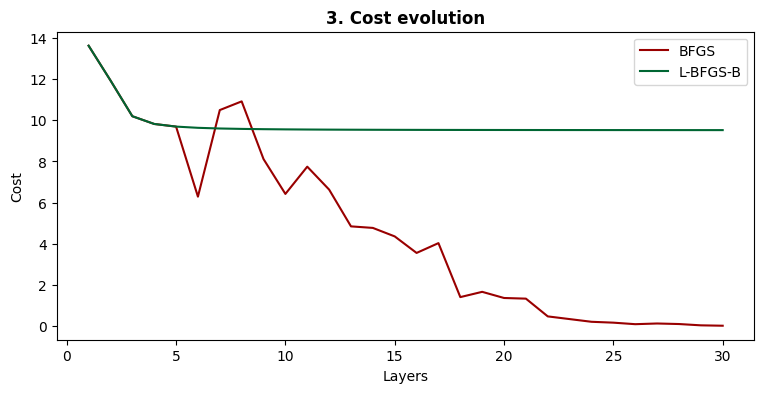

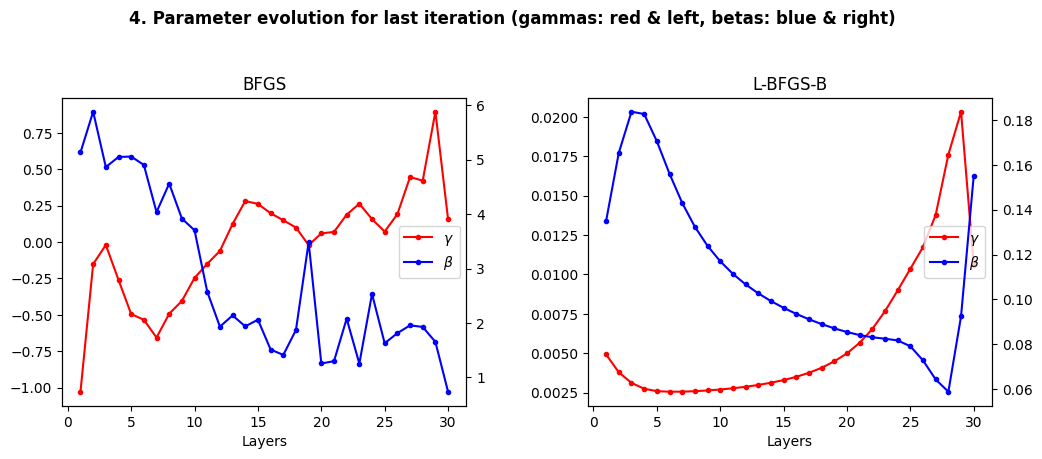

In [17]:
N = 39

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='linear_abs')]
max_layers = 30 # int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 51

## N=51

**1. One layer QAOA**

,N,optimizer,layers,gamma_0,beta_0,gammas,betas,cost,fidelity
695,51,BFGS,1,0.01,1.1,[0.013849093690625001],[1.070235368618127],27.227661,0.012325
745,51,L-BFGS-B,1,0.01,1.1,[0.013849093798469],[1.07023534830555],27.227661,0.012325


**2. State at layers=50**

,N,optimizer,layers,gamma_0,beta_0,cost,fidelity
744,51,BFGS,50,0.01,1.1,0.246868,0.964455
794,51,L-BFGS-B,50,0.01,1.1,0.586150,0.941289


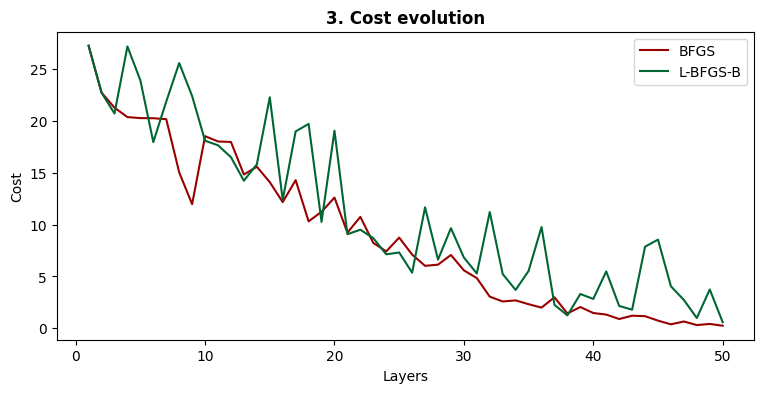

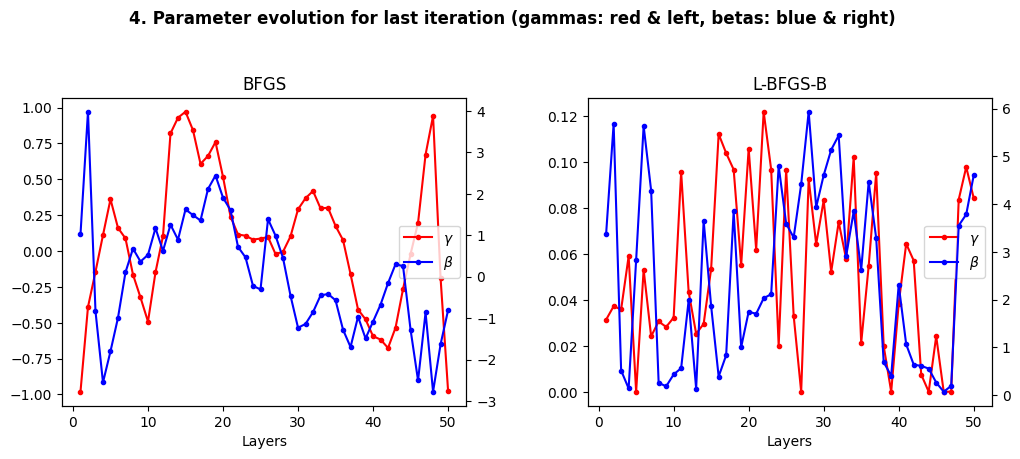

In [18]:
N = 51

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='linear_abs')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 77

## N=77

**1. One layer QAOA**

,N,optimizer,layers,gamma_0,beta_0,gammas,betas,cost,fidelity
439,77,BFGS,10,0.05,2.3,"[0.740975157566358, -0.21855467223391903, 0.18...","[4.16581383062505, 3.8198020194400693, 2.05438...",22.655123,0.082190
389,77,L-BFGS-B,10,0.05,2.3,"[0.082673490883941, 0.052757927992588, 0.03807...","[4.476979597086492, 0.8561116615627371, 1.3254...",18.015488,0.393681


**2. State at layers=50**

,N,optimizer,layers,gamma_0,beta_0,cost,fidelity
479,77,BFGS,50,0.05,2.3,0.349035,0.943610
429,77,L-BFGS-B,50,0.05,2.3,2.295686,0.715756


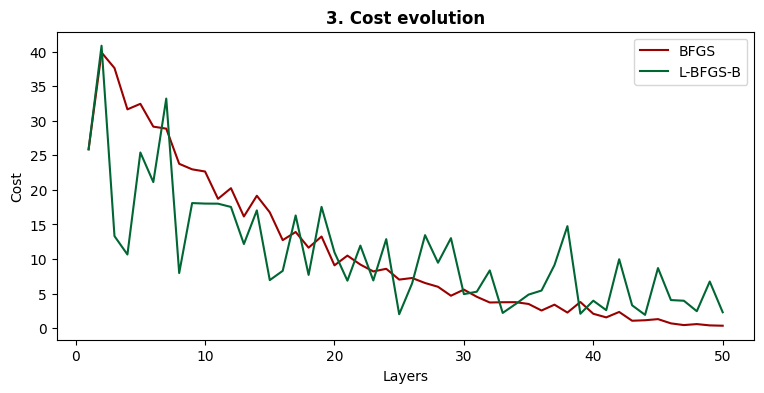

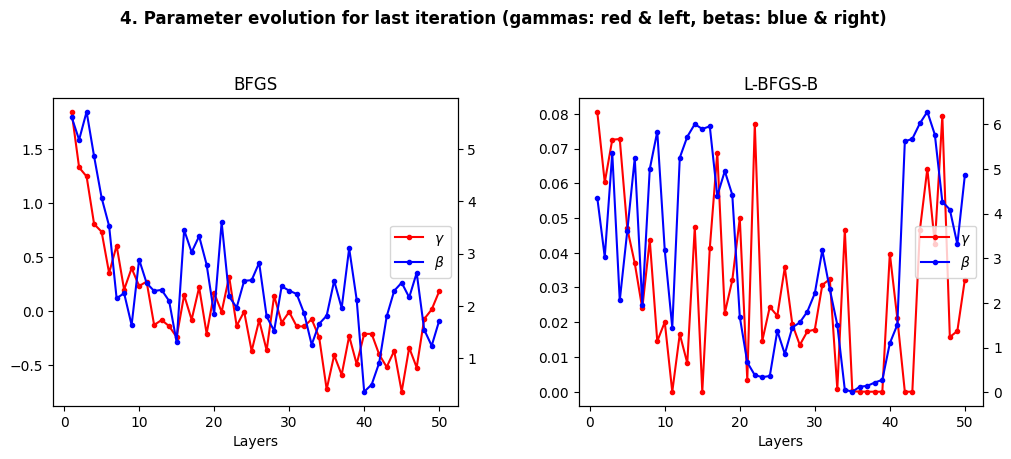

In [19]:
N = 77

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='linear_abs')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==10][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

## Comparison standard (unbounded) vs linear (unbounded)

### N = 21

## N=21

**1. One layer QAOA**

,N,setup,layers,gamma_0,beta_0,gammas,betas,cost,fidelity
510,21,linear_abs,1,0.150,1.5,[0.150167535914248],[1.4849625382688751],6.808984,0.174848
490,21,linear_quadratic,1,0.150,1.5,[0.154564850965925],[1.5075920586575662],74.357584,0.169938
10,21,standard,1,0.007,1.5,[0.008278311895312],[1.529769538903815],32.774907,0.757476


**2. State at layers=10**

,N,setup,layers,gamma_0,beta_0,cost,fidelity
519,21,linear_abs,10,0.150,1.5,1.570371e-17,1.0
499,21,linear_quadratic,10,0.150,1.5,1.943862e-19,1.0
19,21,standard,10,0.007,1.5,5.701687e-22,1.0


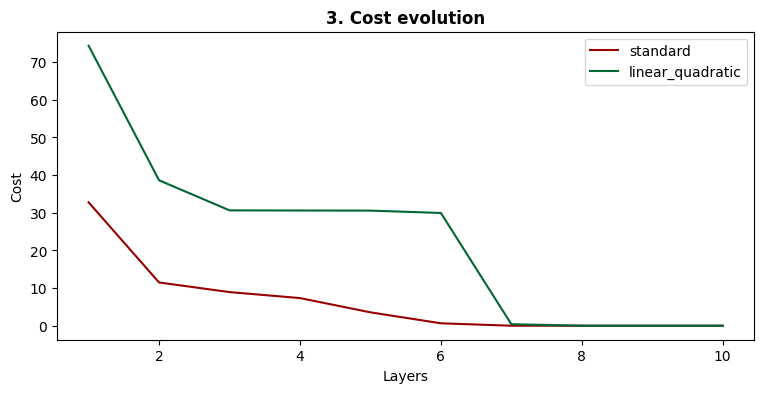

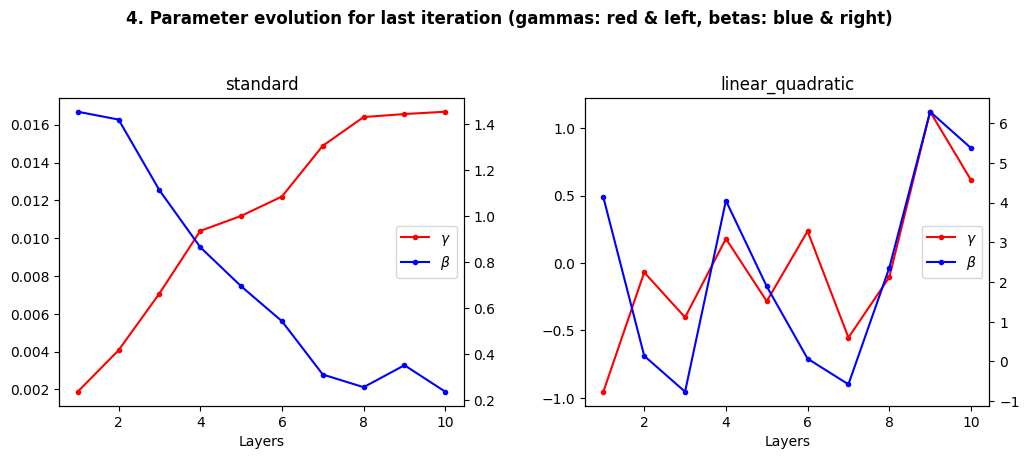

In [20]:
N = 21

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['optimizer']=='BFGS')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'setup', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('setup'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==df['layers'].max()][['N', 'setup', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('setup'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, setup in enumerate(['standard', 'linear_quadratic']):
    df_i = df[df['setup']==setup]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=setup)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, setup in enumerate(['standard', 'linear_quadratic']):
    df_i = df[df['setup']==setup]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(setup)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 39

## N=39

**1. One layer QAOA**

,N,setup,layers,gamma_0,beta_0,gammas,betas,cost,fidelity
1121,39,linear_abs,1,0.050,1.5,[0.043914402413695],[1.491486994085921],13.621065,0.043982
120,39,linear_quadratic,1,0.050,1.5,[0.5293255227265441],[1.3622064923108401],571.618429,0.008020
20,39,standard,1,0.005,0.4,[-0.34753293794883505],[0.835908434859794],593.776847,0.021937


**2. State at layers=50**

,N,setup,layers,gamma_0,beta_0,cost,fidelity
69,39,standard,50,0.005,0.4,2.879670e-23,1.0


ValueError: attempt to get argmax of an empty sequence

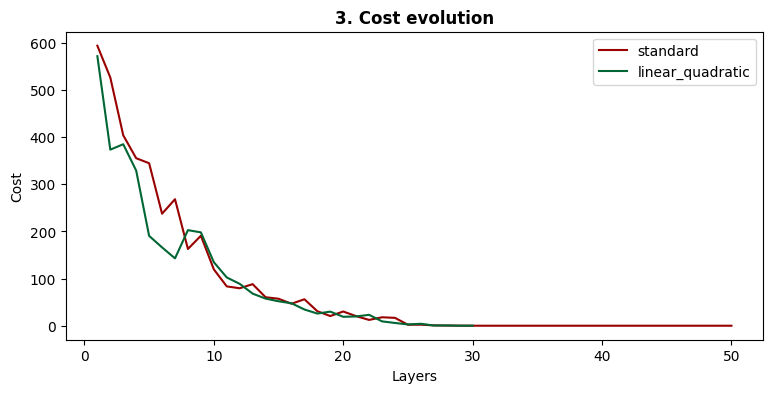

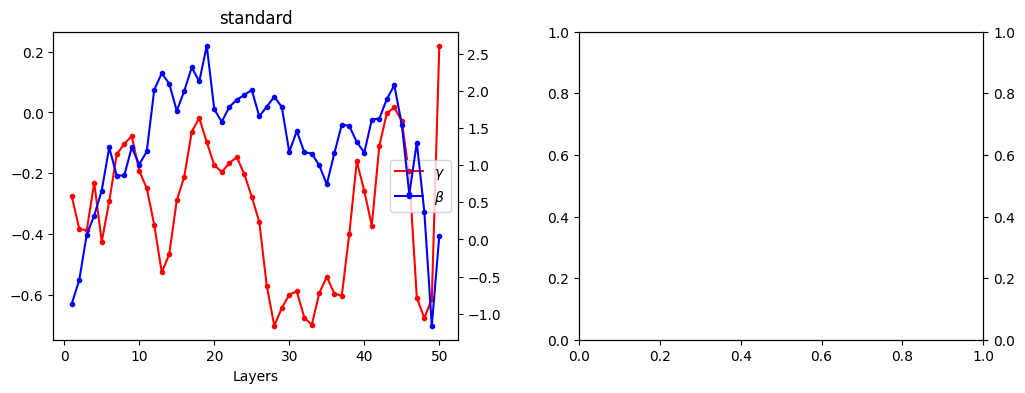

In [21]:
N = 39

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['optimizer']=='BFGS')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'setup', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('setup'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==df['layers'].max()][['N', 'setup', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('setup'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, setup in enumerate(['standard', 'linear_quadratic']):
    df_i = df[df['setup']==setup]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=setup)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, setup in enumerate(['standard', 'linear_quadratic']):
    df_i = df[df['setup']==setup]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(setup)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 51

## N=51

**1. One layer QAOA**

,N,setup,layers,gamma_0,beta_0,gammas,betas,cost,fidelity
695,51,linear_abs,1,0.0100,1.1,[0.013849093690625001],[1.070235368618127],27.227661,0.012325
595,51,linear_quadratic,1,0.0100,1.1,[0.013172117193072002],[1.071317677840412],957.604456,0.012695
330,51,standard,1,0.0001,0.8,[7.653187295904522e-05],[0.6251993693818071],1326.671435,0.023830


**2. State at layers=50**

,N,setup,layers,gamma_0,beta_0,cost,fidelity
744,51,linear_abs,50,0.0100,1.1,0.246868,0.964455
644,51,linear_quadratic,50,0.0100,1.1,6.267255,0.816719
379,51,standard,50,0.0001,0.8,9.025102,0.069025


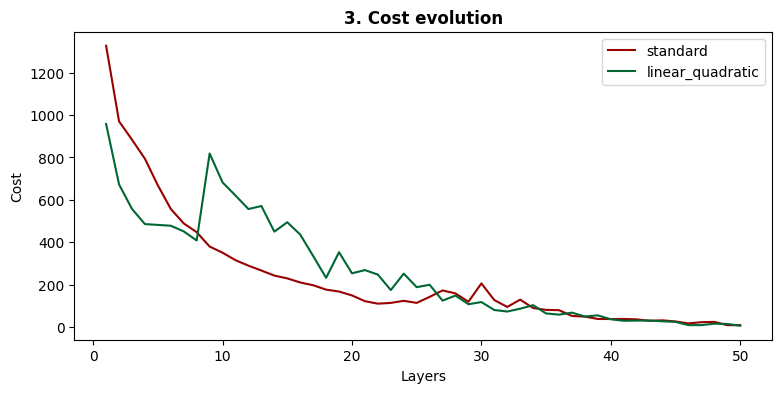

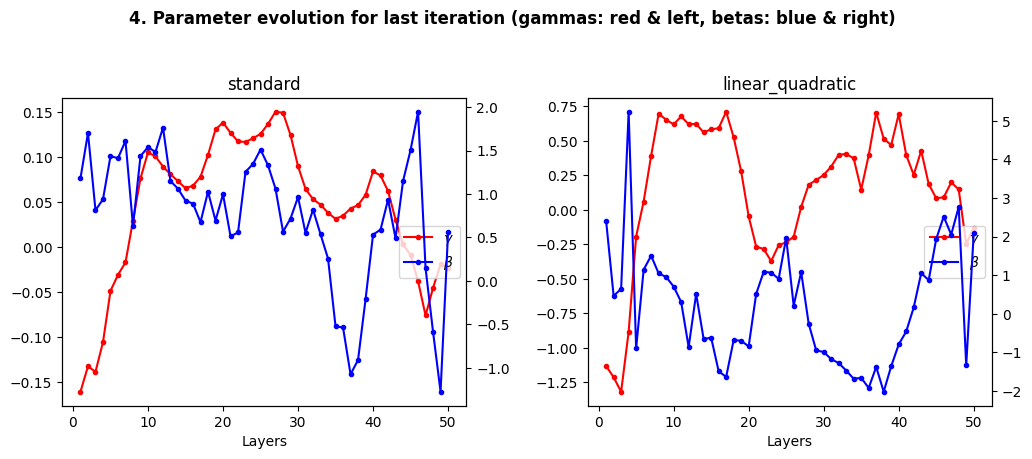

In [ ]:
N = 51

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['optimizer']=='BFGS')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'setup', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('setup'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'setup', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('setup'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, setup in enumerate(['standard', 'linear_quadratic']):
    df_i = df[df['setup']==setup]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=setup)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, setup in enumerate(['standard', 'linear_quadratic']):
    df_i = df[df['setup']==setup]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(setup)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 77

## N=77

**1. One layer QAOA**

,N,setup,layers,gamma_0,beta_0,gammas,betas,cost,fidelity
430,77,linear_abs,1,0.0500,2.30,[0.049438310407823004],[2.219804708201128],25.867042,0.108715
230,77,linear_quadratic,1,0.0500,2.30,[0.049794543256928],[2.270977840921084],1382.099774,0.104663
795,77,standard,1,0.0001,0.39,[0.000108307745618],[0.5230479893037681],1934.541313,0.022078


**2. State at layers=50**

,N,setup,layers,gamma_0,beta_0,cost,fidelity
479,77,linear_abs,50,0.0500,2.30,0.349035,0.943610
279,77,linear_quadratic,50,0.0500,2.30,9.248771,0.318659
844,77,standard,50,0.0001,0.39,9.764248,0.415022


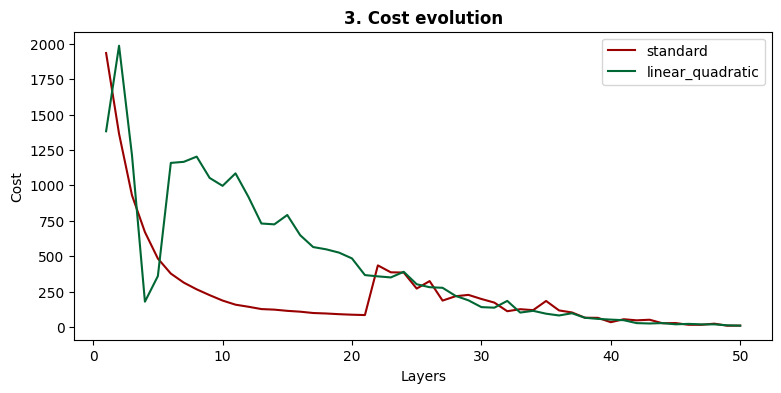

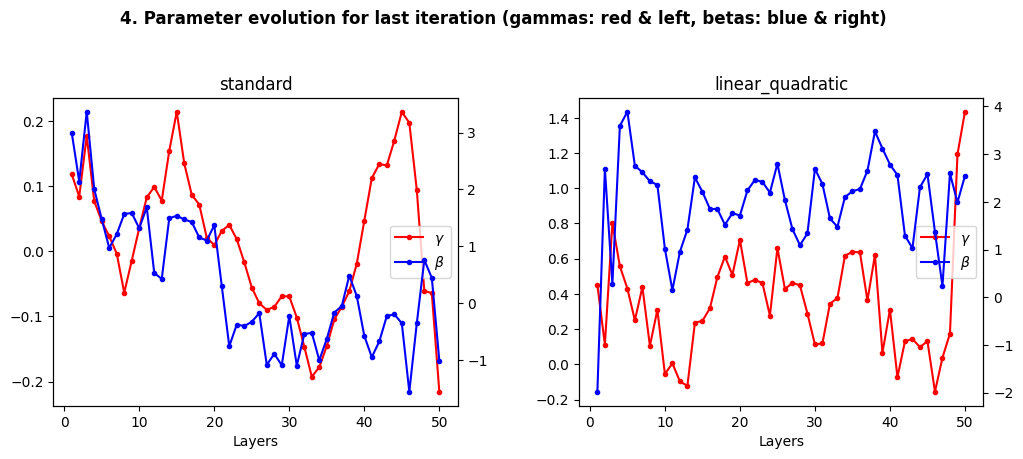

In [ ]:
N = 77

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['optimizer']=='BFGS')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'setup', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('setup'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'setup', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('setup'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, setup in enumerate(['standard', 'linear_quadratic']):
    df_i = df[df['setup']==setup]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=setup)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, setup in enumerate(['standard', 'linear_quadratic']):
    df_i = df[df['setup']==setup]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(setup)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

## Summary

In [ ]:
df = experiment_results[(experiment_results['N'].isin([21,39,51,77]))]
df = df[df['layers']==df['N'].map({21: 10, 39: 30, 51: 50, 77: 50})]
df = df[['N', 'num_qubits','optimizer', 'setup', 'max_layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']]
df = df.rename(columns={'setup': 'protocol'})
pivot = df.pivot_table(values=['cost', 'fidelity'], index=['N'], columns=['protocol', 'optimizer'])
pivot.columns = pivot.columns.reorder_levels(['protocol', 'optimizer', None])
pivot = pivot.sort_index(axis=1, level=[0,1,2], ascending=[False, False, True])

pivot

protocol       standard                                   linear_quadratic  \
optimizer      L-BFGS-B                    BFGS                   L-BFGS-B   
                   cost  fidelity          cost  fidelity             cost   
N                                                                            
21         2.852285e-09  1.000000  5.701687e-22  1.000000        38.622113   
39         1.571797e+01  0.386585  1.600927e-02  0.999343       129.967519   
51         7.678049e+01  0.155842  9.025102e+00  0.069025        66.013635   
77         5.623824e+01  0.138790  9.764248e+00  0.415022       194.919376   

protocol                                    linear_abs            \
optimizer                    BFGS             L-BFGS-B             
           fidelity          cost  fidelity       cost  fidelity   
N                                                                  
21         0.130203  1.943862e-19  1.000000   5.524890  0.149457   
39         0.016010  5.189759e-02  0.998990   9.522119  0.016777   
51         0.342925  6.267255e+00  0.816719   0.586150  0.941289   
77         0.322893  9.248771e+00  0.318659   2.295686  0.715756   

protocol                           
optimizer          BFGS            
                   cost  fidelity  
N                                  
21         1.570371e-17  1.000000  
39         2.120815e-02  0.997213  
51         2.468680e-01  0.964455  
77         3.490353e-01  0.943610

In [ ]:
df = experiment_results[(experiment_results['N'].isin([21,39,51,77])) & (experiment_results['setup']=='linear_abs')]
df = df[df['layers']==df['N'].map({21: 10, 39: 30, 51: 50, 77: 50})]
df = df[['N', 'layers', 'num_qubits','optimizer', 'setup', 'max_layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']]
df = df.rename(columns={'setup': 'protocol'})
pivot = df.pivot_table(values=['cost', 'fidelity'], index=['N', 'layers'], columns=['optimizer'])
pivot.columns = pivot.columns.reorder_levels(['optimizer', None])
pivot = pivot.sort_index(axis=1, level=[0,1], ascending=[False, True])

pivot

optimizer  L-BFGS-B                    BFGS          
               cost  fidelity          cost  fidelity
N  layers                                            
21 10      5.524890  0.149457  1.570371e-17  1.000000
39 30      9.522119  0.016777  2.120815e-02  0.997213
51 50      0.586150  0.941289  2.468680e-01  0.964455
77 50      2.295686  0.715756  3.490353e-01  0.943610

## Extras

### Probability distributions

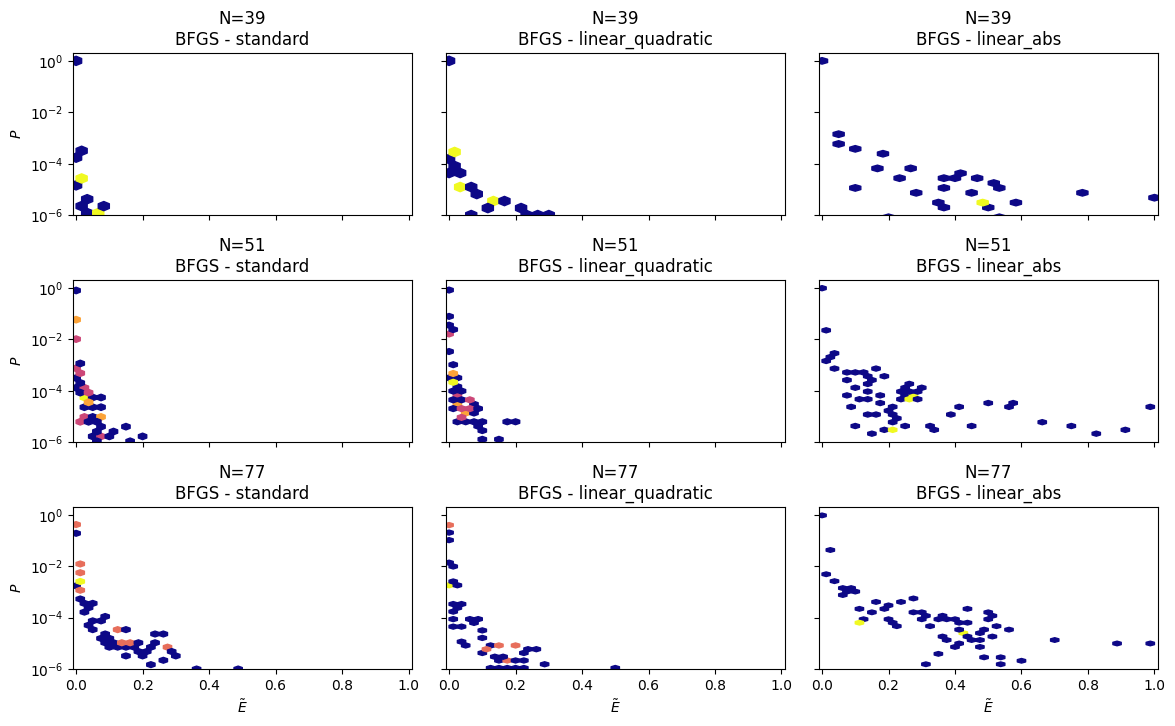

In [ ]:
Ns = [39,51,77]
layers_map = {21: 10, 39: 30, 51: 50, 77: 50}
gridsize_map = {39: 30, 51: 40, 77:40}

df = experiment_results[(experiment_results['N'].isin(Ns)) & (experiment_results['optimizer']=='BFGS')]
df = df[df['layers']==df['N'].map(layers_map)]

fig, axs = plt.subplots(nrows=len(Ns), ncols=3, figsize=(14,8), sharey=True, sharex=True)
fig.subplots_adjust(hspace=0.4, wspace=0.1)

for i, N in enumerate(Ns):
    for j, setup in enumerate(['standard', 'linear_quadratic', 'linear_abs']):
        ax = axs[i][j]
        df_s = df[(df['N']==N) & (df['setup']==setup)].reset_index()

        probs = df_s.loc[0,'state_populations']
        energies = np.array(df_s.loc[0,'Ec'])
        layer_max = df_s.loc[0, 'layers']

        E_min = np.min(energies)
        E_max = np.max(energies)
        rescaled_E = (energies - E_min) / (E_max - E_min)
        

        hb = ax.hexbin(rescaled_E, probs, gridsize=gridsize_map[N], cmap='plasma', bins='log', yscale='log')
        ax.set_title(f"N={N}\n{optimizer} - {setup}")
        ax.set_xlim(-0.01,1.01)
        ax.set_ylim(1e-6,2)
        if j == 0:
            ax.set_ylabel('$P$')
        if i == 2:
            ax.set_xlabel('$\\tilde{E}$')

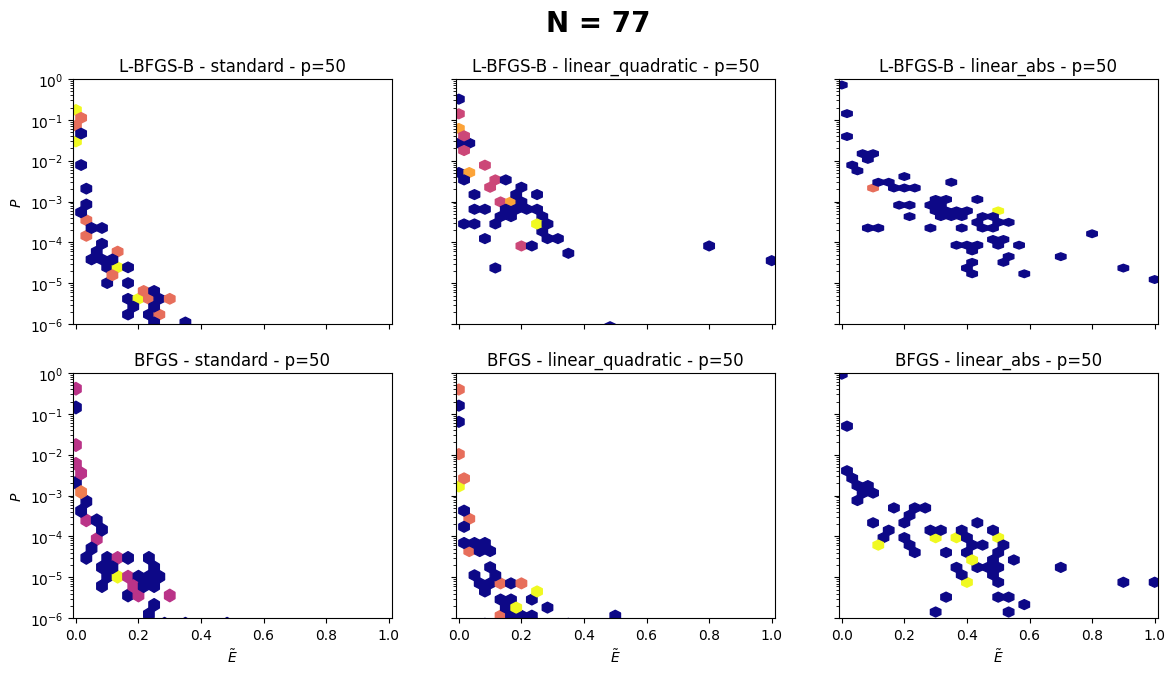

In [ ]:
N = 77

df = experiment_results[(experiment_results['N']==N)]
df = df[df['layers']==df.groupby('setup')['layers'].max().min()]

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(14,7), sharey=True, sharex=True)
fig.subplots_adjust(hspace=0.2)

for i, optimizer in enumerate(['L-BFGS-B', 'BFGS']):
    for j, setup in enumerate(['standard', 'linear_quadratic', 'linear_abs']):
        ax = axs[i][j]
        df_s = df[(df['setup']==setup) & (df['optimizer']==optimizer)]
        layer_max = df_s['layers'].max()
        df_s = df_s[df_s['layers'] == layer_max].reset_index(drop=True)

        probs = df_s.loc[0,'state_populations']
        energies = np.array(df_s.loc[0,'Ec'])

        E_min = np.min(energies)
        E_max = np.max(energies)
        rescaled_E = (energies - E_min) / (E_max - E_min)

        hb = ax.hexbin(rescaled_E, probs, gridsize=30, cmap='plasma', bins='log', yscale='log')
        ax.set_title(f"{optimizer} - {setup} - p={layer_max}")
        ax.set_xlim(-0.01,1.01)
        ax.set_ylim(1e-6,1)
        if j == 0:
            ax.set_ylabel('$P$')
        if i == 1:
            ax.set_xlabel('$\\tilde{E}$')

fig.suptitle(f'N = {N}', fontsize=20, fontweight='bold');


### Others

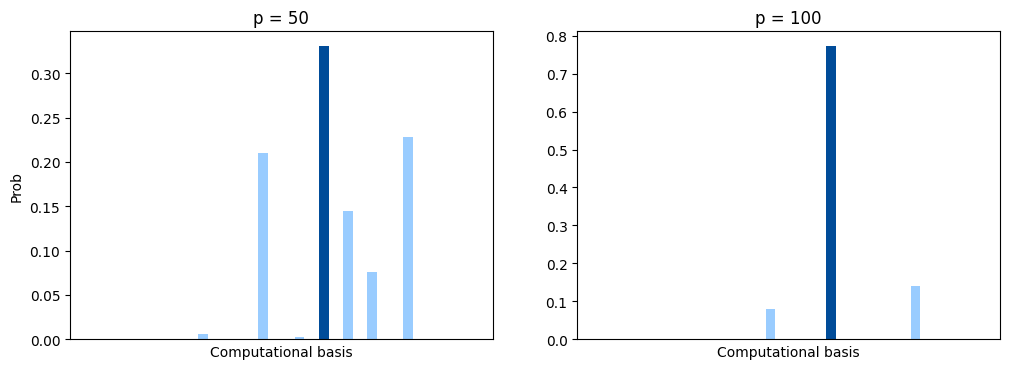

In [ ]:
N = 39
gamma_0 = 0.0004
beta_0 = 0.5

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='standard')
                        & (experiment_results['optimizer']=='L-BFGS-B')
                        & (experiment_results['gamma_0']==gamma_0)
                        & (experiment_results['beta_0']==beta_0)].reset_index(drop=True)

num_qubits = df.loc[0, 'num_qubits']
solutions = compute_solution(N)
x_hist = [int_to_binary_str(n, num_qubits) for n in range(2**num_qubits)]
bar_colors = [plot_colors[1][0] if c in solutions else plot_colors[1][1] for c in x_hist]

pops_50 =  df[df['layers']==50].reset_index().loc[0, 'state_populations']
pops_100 =  df[df['layers']==100].reset_index().loc[0, 'state_populations']

fig, axs = plt.subplots(1,2, figsize=(12,4))

axs[0].bar(x_hist, pops_50, color=bar_colors)
axs[1].bar(x_hist, pops_100, color=bar_colors)
axs[0].set_ylabel('Prob')
axs[0].set_xlabel('Computational basis')
axs[1].set_xlabel('Computational basis')

axs[0].set_xticks(range(2**num_qubits), "")
axs[0].xaxis.set_major_locator(ticker.NullLocator())
axs[0].set_title('p = 50')
axs[1].set_xticks(range(2**num_qubits), "")
axs[1].xaxis.set_major_locator(ticker.NullLocator())
axs[1].set_title('p = 100');

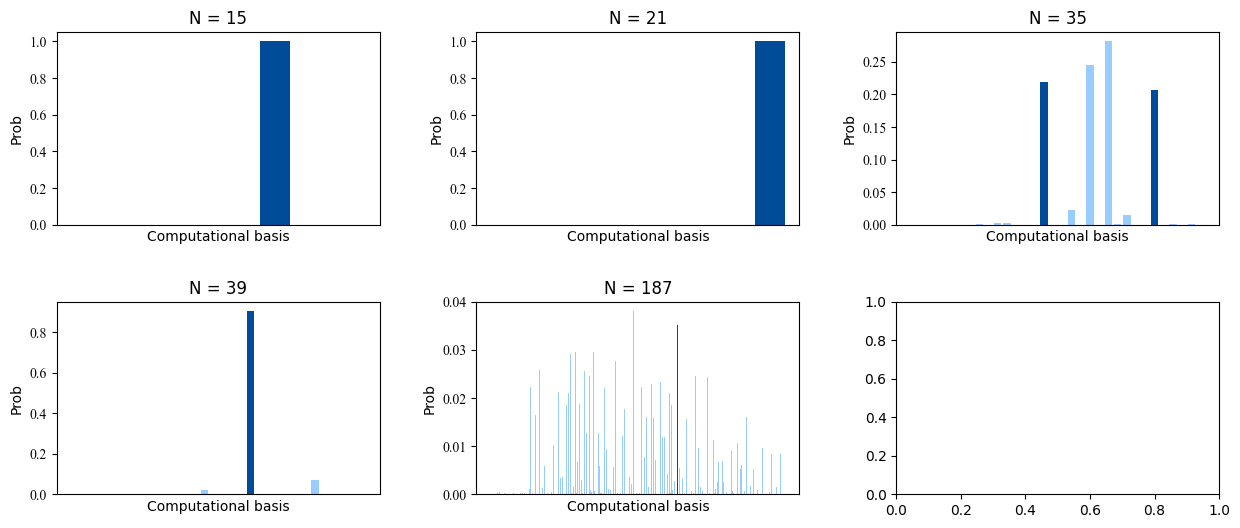

In [ ]:
df = experiment_results[(experiment_results['setup']=='standard') & (experiment_results['optimizer']=='L-BFGS-B')
                        & (experiment_results['N']<=187)]
df = df.groupby(['N','layers']).last().reset_index()
Ns = sorted(df['N'].unique())

ncols = 3
nrows = math.ceil(len(Ns) / ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols,3*nrows))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
axs = axs.flatten()

for i, N in enumerate(Ns):
    df_N = df[df['N']==N].reset_index()
    idx_last_layer = df_N['layers'].idxmax()
    num_qubits = df_N.loc[idx_last_layer, 'num_qubits']
    solutions = compute_solution(N)
    x_hist = [int_to_binary_str(n, num_qubits) for n in range(2**num_qubits)]

    pops =  df_N.loc[idx_last_layer, 'state_populations']

    bar_colors = [plot_colors[1][0] if c in solutions else plot_colors[1][1] for c in x_hist]

    axs[i].bar(x_hist, pops, color=bar_colors)
    axs[i].set_ylim(0)
    axs[i].set_ylabel('Prob')
    axs[i].set_xlabel('Computational basis')

    labels = (axs[i].get_xticklabels() + axs[i].get_yticklabels())

    for label in labels:
        label.set_fontname('Times New Roman')

    axs[i].set_xticks(range(2**num_qubits), "")
    axs[i].xaxis.set_major_locator(ticker.NullLocator())
    axs[i].set_title(f'N = {N}')

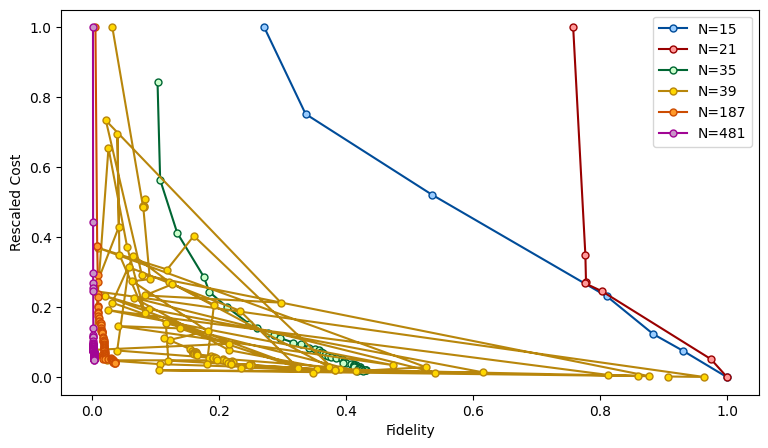

In [ ]:
df = experiment_results[(experiment_results['setup']=='standard')
                        & (experiment_results['optimizer']=='L-BFGS-B')
                        & (experiment_results['N']!=119)]
df = df.groupby(['N','layers']).last().reset_index()
Ns = sorted(df['N'].unique())

fig = plt.figure(figsize=(9,5))

for i, N in enumerate(Ns):
    df_N = df[df['N']==N]
    plt.plot(df_N['fidelity'], df_N['cost_rescaled'], label=f'N={N}',
             color=plot_colors[i+1][0], mec=plot_colors[i+1][0], mfc=plot_colors[i+1][1], marker='.',
             markersize=10)

plt.xlabel('Fidelity')
plt.ylabel('Rescaled Cost')
#plt.yscale('log')
plt.legend(loc='best')
#plt.show()

# plt.savefig('../report_1/img/cost_fidelity.pdf')